In [1]:
import time
print("Last updated on ", time.asctime())

Last updated on  Tue Oct 23 20:51:18 2018


In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
import os
import time
import datetime

import tables            as tb
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib.dates  as md
import collections       as collections
import pandas            as pd

from   scipy import optimize
from  invisible_cities.core .core_functions import in_range

import krcal.utils.plt_functions          as krplot
import krcal.utils.hst_extend_functions   as hst

In [4]:
# Plotting style
default_cmap = "jet"
figure_size  = 14, 8
font_size    = 14

plt.rcParams["figure.figsize"] =   figure_size
plt.rcParams[  "font.size"   ] =   font_size

In [5]:
run_number = 6348
trigger    = 'trigger1'
input_filename = f"$IC_DATA/{run_number}/pmaps/edf_{run_number}_0_3999_{trigger}.h5"
input_file     = os.path.expandvars(input_filename)

In [6]:
hd = pd.HDFStore(input_file)

In [7]:
edf = hd['edf']
edf.head()

,event,peak,loc,nslices,nhits,noqhits,time,s1e,t0,rmax,...,x0,y0,z0,q0,e0,x,y,z,q,e
0,1,0,0,9,27,72,1538211719063,10.071146,496.368983,183.439363,...,-160.617097,-47.687340,156.846939,375.382202,10037.158203,-160.656984,-47.724445,156.849109,359.624612,10313.143501
1,2,0,0,8,21,46,1538211719077,6.134734,602.205231,82.764727,...,-22.192036,68.026299,49.686260,446.840271,11015.997070,-22.248531,68.069196,49.686675,454.984373,9920.639032
2,7,0,0,7,20,51,1538211719143,42.502666,546.979282,177.341479,...,-157.890947,-52.264471,105.389221,285.282196,7255.624023,-157.913075,-52.294749,105.390246,269.078296,7338.648922
3,7,1,0,10,72,202,1538211719143,42.502666,546.979282,199.624648,...,-159.738017,-71.116222,124.939949,1817.674316,31202.865234,-159.769408,-70.991400,124.941938,1693.406091,32612.995770
4,12,0,0,8,26,60,1538211719230,11.110806,536.571943,35.355339,...,-14.343082,-16.338275,116.240067,421.961365,11570.751953,-14.428775,-16.364938,116.238875,425.056071,9975.203260


In [8]:
edf = edf.dropna()

pk  = edf.peak
E   = edf.e
Q   = edf.q
X   = edf.x
Y   = edf.y
R   = np.sqrt(X*X + Y*Y)
Z   = edf.z
ns  = edf.nslices
nh  = edf.nhits
S1e = edf.s1e
ts  = edf.time
t0  = edf.t0

/Users/hernando/miniconda/envs/IC-3.6-2018-08-29/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


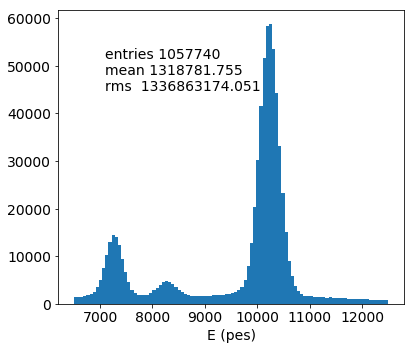

In [9]:
Ea = hst.Vaxis((6.5e3, 12.5e3), 100)
c = hst.Canvas(1, 1)
hst.hist(E, Ea.bins, canvas = c(1), xylabels=('E (pes)', ''));

In [10]:
XYa = hst.Vaxis((-200, 200), 80)

In [11]:
sel = (E > 0) & (Z < 600) & (R < 180.)

/Users/hernando/miniconda/envs/IC-3.6-2018-08-29/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


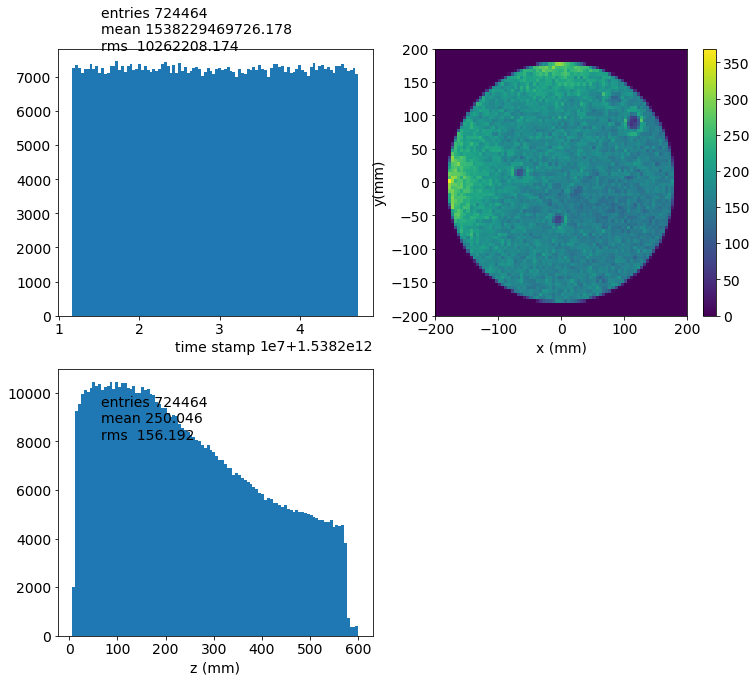

In [12]:
c = hst.Canvas(2, 2)
hst.hist(ts[sel], 100                          , canvas = c(1), xylabels=('time stamp', ''))
hst.hist2d(X[sel], Y[sel], (XYa.bins, XYa.bins), canvas = c(2), xylabels=('x (mm)', 'y(mm)'));
plt.colorbar();
hst.hist(Z[sel], 100                           , canvas = c(3), xylabels=('z (mm)', '' ));
#hst.hist(t0[sel], 100                          , canvas = c(4), xylabels=('t0 (us)', '' ));

In [13]:
def fun_gaus(x, A, mu, sig):
    return A * np.e**(-(x-mu)**2/(2*sig*sig)) 

def fun_gausline(x, A, mu, sig, a, b):
    return A * np.e**(-(x-mu)**2/(2*sig*sig)) + a*x + b

def guess_gaus(v):
    A, mu, sig = len(v), np.mean(v), np.std(v)
    return A, mu, sig

def guess_gausline(v):
    A, mu, sig = guess_gaus(v)
    y, x = np.histogram(v, 10)
    a, b = y[0], (y[-1]-y[0])/(x[-1]-x[0])
    return A, mu, sig, a, b
    
def chisq(F, popt, xdata, ydata):
    return np.sum((F(xdata, *popt)-ydata)**2/((len(xdata)-len(popt))*ydata))

def fit_fun(x, y, fun, guess):
    popt, pcov = optimize.curve_fit(fun, x, y, p0 = guess, sigma = np.sqrt(y))
#                                    bounds=([-np.inf, 0, -np.inf, -np.inf, 0.], 5*[np.inf, ]))
#    Eph, sig, A, m, c = popt[0], popt[1], popt[2], popt[3], popt[4]
    return popt

def text_fitgaus(mu, sig, chi2):
    t = (r"$\mu$ : {}"     .format(round(mu, 1)) + 
         "\n" + "$\sigma$ : {}" .format(round(sig, 1))  +
         "\n" + r"FWHM : {}"    .format(round(sig / mu * 235, 2)) + 
         "\n" + r"$\chi^2$ : {}".format(round(chi2,2))) 
    return t
    
def rel_pos(xcenters, yvals, x0=0.75, y0 = 0.6):
    xi = x0 * (np.max(xcenters)-np.min(xcenters)) + np.min(xcenters)
    yi = y0 * (np.max(yvals)-np.min(yvals))       + np.min(yvals)
    return xi, yi

In [14]:
def plot_gausline(V, xbins, comment=''):
    
    dys, dxs = np.histogram(V, xbins)
    guess = guess_gausline(V)
    plt.hist(V, xbins)
    
    #print('guess parameters    :', guess)
    xcenters = 0.5*(xbins[:-1]+xbins[1:])
    phat = fit_fun(xcenters, dys, fun_gausline, guess)
    plt.plot(dxs, fun_gausline(dxs, *phat), lw=3, ls='--')
    plt.xlabel('E (pes)')
    plt.title(comment)
    #print('estimated parameters: ', phat)
    chi2 = chisq(fun_gausline, phat, xcenters, dys)
    #print('chi2$: ', chi2)

    x0, y0 = rel_pos(xcenters, dys)
    text   = text_fitgaus(phat[1], phat[2], chi2)
    #print(text)
    plt.text(x0, y0, text, fontsize = 11);
    return xcenters, phat, chi2

/Users/hernando/miniconda/envs/IC-3.6-2018-08-29/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


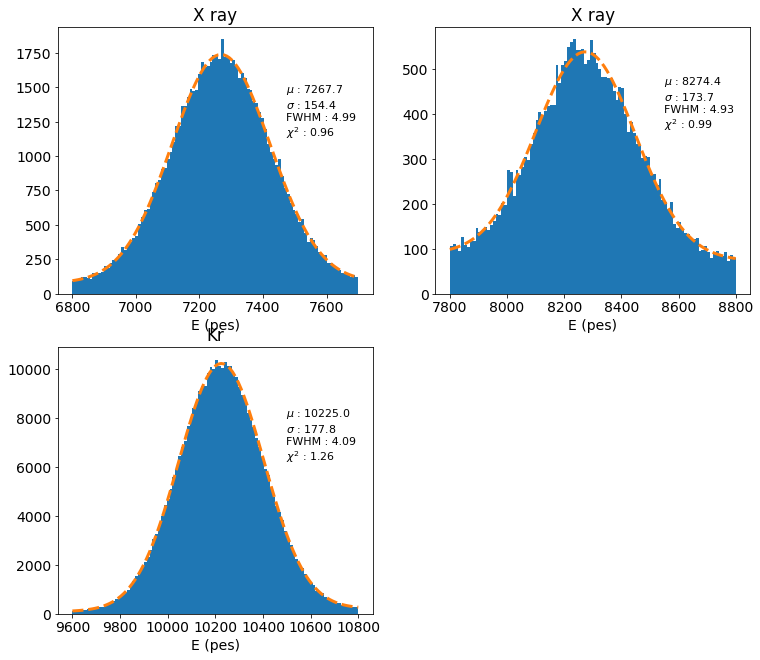

In [15]:
sel = (E > 0) & (Z > 0) & (Z < 550) & (R < 180.)
c = hst.Canvas(2, 2)
c(1)
Exa = hst.Vaxis((6.8e3, 7.7e3), 100)
xsel = in_range(E, *Exa.range) & sel
x1, p1, chi1 = plot_gausline(E[xsel], Exa.bins, 'X ray');
c(2)
Exa = hst.Vaxis((7.8e3, 8.8e3), 100)
xsel = in_range(E, *Exa.range) & sel
x2, p2, chi2 = plot_gausline(E[xsel], Exa.bins, 'X ray');
c(3)
Eka = hst.Vaxis((9.6e3, 10.8e3), 100)
ksel = in_range(E, *Eka.range) & sel
x3, p3, chi3 = plot_gausline(E[ksel], Eka.bins, 'Kr');


$\mu$ : 10214.9	 $\sigma$ : 174.2	 FWHM : 4.01
$\mu$ : 8266.8	 $\sigma$ : 170.9	 FWHM : 4.86
$\mu$ : 7261.3	 $\sigma$ : 151.4	 FWHM : 4.9


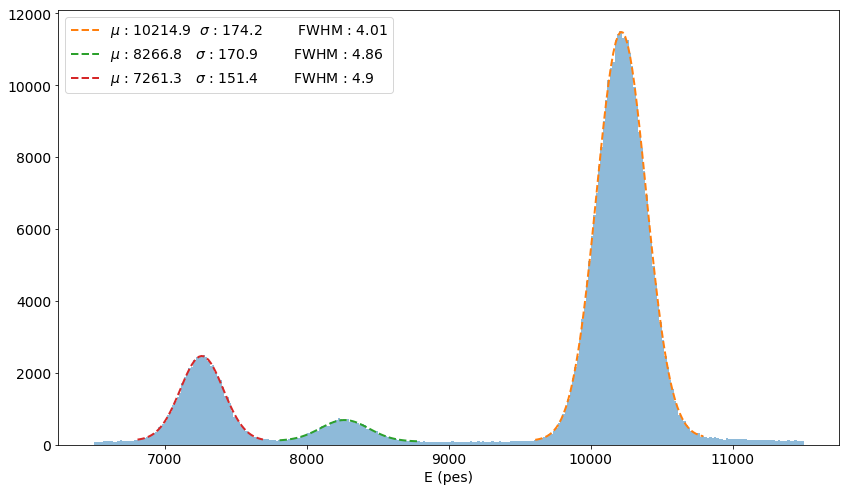

In [16]:
sel = (E > 0) & (Z > 0) & (Z < 550) & (R < 160.)

#fig = plt.figure(figsize=(8, 6));
Ea = hst.Vaxis((6.5e3, 11.5e3), 300)
xsel = in_range(E, *Ea.range) & sel
plt.hist(E[sel], Ea.bins, alpha = 0.5);
plt.xlabel('E (pes)')
ys, xes = np.histogram(E[sel], Ea.bins)

def _grange(eini, eend):

    Eka   = hst.Vaxis( (eini, eend), 100)
    xkrsel = in_range(Ea.centers, *Eka.range)
    ekrsel = (in_range(E, *Eka.range)) & sel
    guess = guess_gausline(E[ekrsel])
    krphat = fit_fun(Ea.centers[xkrsel], ys[xkrsel], fun_gausline, guess)
    xx = Ea.centers[xkrsel]
    mu, sig, = krphat[1], krphat[2]
    t = r"$\mu$ : {}".format(round(mu, 1))+ "\t $\sigma$ : {}".format(round(sig, 1))+"\t FWHM : {}".format(round(sig / mu * 235, 2))
    print(t)
    plt.plot(xx, fun_gausline(xx, *krphat), lw=2, ls='--', label = t)

_grange(9.6e3, 10.8e3)
_grange(7.8e3, 8.8e3)
_grange(6.8e3, 7.7e3)
    
plt.legend();


/Users/hernando/miniconda/envs/IC-3.6-2018-08-29/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


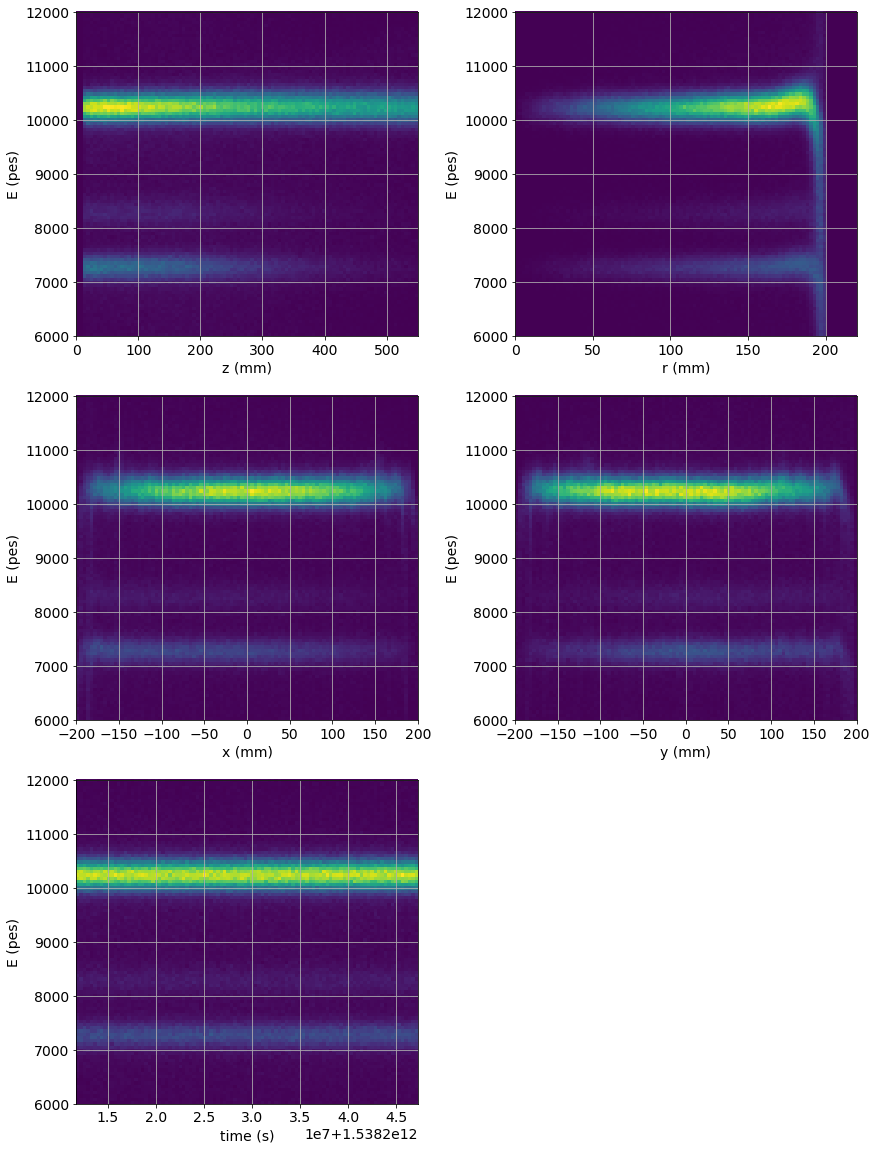

In [17]:
c = hst.Canvas(3, 2)
eini, eend = 6e3, 12e3
sel = (E > eini) & (E < eend) & (Z > 0) & (Z < 550) & (R < 200.)
c(1)
plt.hist2d(Z[sel], E[sel], (100, 100), ((0, 550.), (eini, eend)) );
plt.xlabel('z (mm)')
plt.ylabel('E (pes)')
plt.grid()
c(2)
plt.hist2d(R[sel], E[sel], (100, 100), ((0, 220.), (eini, eend)) );
plt.xlabel('r (mm)')
plt.ylabel('E (pes)')
plt.grid()
c(3)
plt.hist2d(X[sel], E[sel], (100, 100), ((-200., 200.), (eini, eend)));
plt.xlabel('x (mm)')
plt.ylabel('E (pes)')
plt.grid()
c(4)
plt.hist2d(Y[sel], E[sel], (100, 100), ((-200., 200.), (eini, eend)));
plt.xlabel('y (mm)')
plt.ylabel('E (pes)')
plt.grid()
c(5)
plt.hist2d(ts[sel], E[sel], (100, 100), ((ts.min(),ts.max()), (eini, eend)));
plt.xlabel('time (s)')
plt.ylabel('E (pes)')
plt.grid()
plt.tight_layout()

/Users/hernando/miniconda/envs/IC-3.6-2018-08-29/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


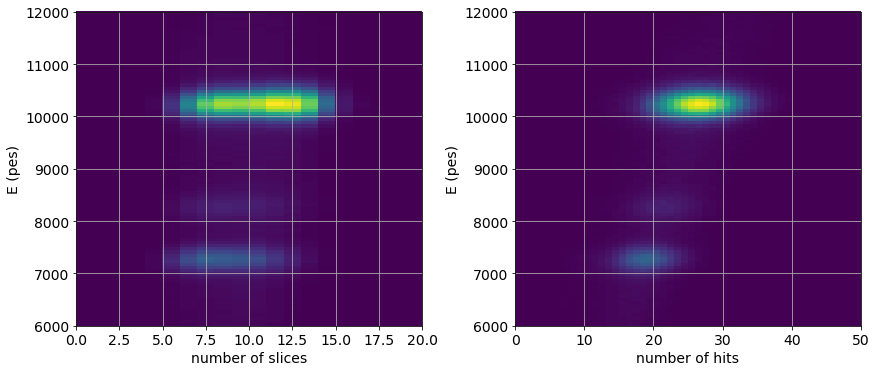

In [18]:
c = hst.Canvas(1, 2)
eini, eend = 6e3, 12e3
sel = (E > eini) & (E < eend) & (Z > 0) & (Z < 550) & (R < 200.)
c(1)
plt.hist2d(ns[sel], E[sel], (20, 100), ((0, 20.), (eini, eend)) );
plt.xlabel('number of slices')
plt.ylabel('E (pes)')
plt.grid()
c(2)
plt.hist2d(nh[sel], E[sel], (50, 100), ((0, 50.), (eini, eend)) );
plt.xlabel('number of hits')
plt.ylabel('E (pes)')
plt.grid()
plt.tight_layout()

/Users/hernando/miniconda/envs/IC-3.6-2018-08-29/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


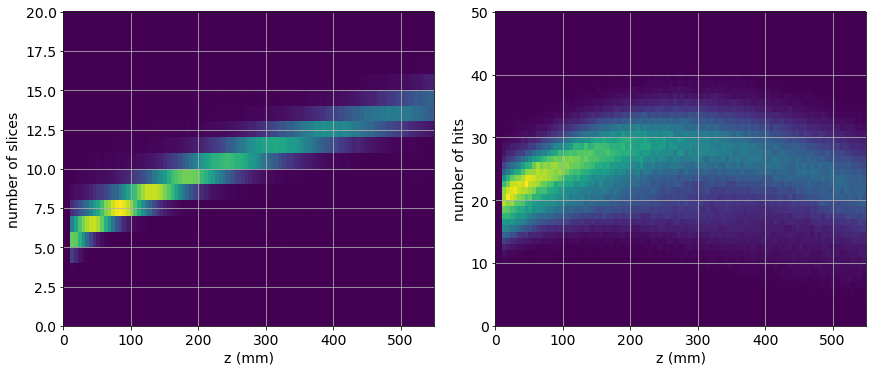

In [19]:
c = hst.Canvas(1, 2)
eini, eend = 6e3, 12e3
sel = (E > eini) & (E < eend) & (Z > 0) & (Z < 550) & (R < 200.)
c(1)
plt.hist2d(Z[sel], ns[sel], (100, 20), ((0, 550.), (0., 20.)) );
plt.ylabel('number of slices')
plt.xlabel('z (mm)')
plt.grid()
c(2)
plt.hist2d(Z[sel], nh[sel], (100, 50), ((0, 550.), (0., 50.)) );
plt.ylabel('number of hits')
plt.xlabel('z (mm)')
plt.grid()
plt.tight_layout()